In [1]:
# testing 25 nih models
# young = 0-5
# old = 6-18
# same train-val-test split is kept, except for test set we are now testing young vs old 
import subprocess
import pandas as pd 
import os
import glob

parent = '/home/jkim/research/peds_cxr/'
gpu = "1"
predefined_seeds = [9,17,18,29,30,34,41,42,51,52,61,66,74,75,78,81,84,86,87,89,90,92,96,98,99]

# batch creating result directiory
for seed in predefined_seeds:
    for dir in ['all', 'young', 'old']:
        # Construct the new directory path for results
        new_result_dir = parent + f"25variation/results/nih/test/{dir}/nih_{seed}_{dir}/"
        
        # Create the new directory if it doesn't exist
        if not os.path.exists(new_result_dir):
            os.makedirs(new_result_dir)

for seed in predefined_seeds:
    nih_metadata_path = parent + '25variation/metadata/final/nih/nih_metadata_seed_' + str(seed) + '.csv'
    nih_metadata = pd.read_csv(nih_metadata_path)
    
    # Convert 'Patient Age' to integers
    nih_metadata['Patient Age'] = pd.to_numeric(nih_metadata['Patient Age'], errors='coerce')

    # Creating nih_test_young / old .txt
    age_groups = ['young', 'old']
    for age_group in age_groups:
        if age_group == 'young':
            test_index = nih_metadata[(nih_metadata['Set'] == 'test') & (nih_metadata['Patient Age'] >= 0) & (nih_metadata['Patient Age'] <= 5)]
        else:  # 'old'
            test_index = nih_metadata[(nih_metadata['Set'] == 'test') & (nih_metadata['Patient Age'] >= 6) & (nih_metadata['Patient Age'] <= 18)]
        
        image_source = parent + '25variation/images/nih/nih_' + str(seed) + '/'
        nih_test_output = image_source + 'nih_test_'+ age_group +'.txt'
        nih_test_txt = test_index['Image Index']
        nih_test_txt.to_csv(nih_test_output, sep=',', index=False, header=False)


In [2]:
# Testing old vs young
ages = ['young', 'old']
for age in ages:
    for seed in predefined_seeds:
    # Build the pattern to search for model files
        search_pattern = os.path.join(parent, f"25variation/results/nih/train/nih_{seed}/DenseNet121_lr0.005_bs16_optSGD_wd0.0001_sch_step_pp3_bp5_trtrain.txt_vaval.txt_tfpeds_nlbatch_do0.0_*_model.pt")
        # Use glob to find the file
        matching_files = glob.glob(search_pattern)
        
        # Check if any matching files are found
        if not matching_files:
            print(f"No matching model files found for seed {seed}.")
            continue  # Skip to the next iteration

        # Assuming there's only one matching file, take the first one
        model_file_path = matching_files[0]

        image_source = parent + f'25variation/images/nih/nih_{seed}/' 
        command = [
            "python3",
            parent + "transformer-radiographs/test_cxr.py",
            "--cfg-dir", parent + f"25variation/images/nih/nih_{seed}/cfg_nih_{seed}.json",
            "--dataset", f'nih_{seed}',
            "--labels-set", "labels",
            "--model-state", model_file_path,
            "--model-type", "DenseNet121",
            "--results-dir", parent + f"25variation/results/nih/test/{age}/nih_{seed}_{age}",
            "--test-file", image_source + "nih_test_" + age + ".txt",
            "--use-gpus", gpu
    ]

        # Run the command
        try:
            subprocess.run(command, check=True)
        except subprocess.CalledProcessError as e:
            print(f"An error occurred while executing the command: {e}")


Test set: starting load
Using image path file
Using no transforms
Loaded 74 images
Device: cuda #: 1 #cpus: 128

dict_keys(['nih_9_DenseNet121_nih_test_young'])

Test set: starting load
Using image path file
Using no transforms
Loaded 74 images
Device: cuda #: 1 #cpus: 128

dict_keys(['nih_17_DenseNet121_nih_test_young'])

Test set: starting load
Using image path file
Using no transforms
Loaded 74 images
Device: cuda #: 1 #cpus: 128

dict_keys(['nih_18_DenseNet121_nih_test_young'])

Test set: starting load
Using image path file
Using no transforms
Loaded 74 images
Device: cuda #: 1 #cpus: 128

dict_keys(['nih_29_DenseNet121_nih_test_young'])

Test set: starting load
Using image path file
Using no transforms
Loaded 74 images
Device: cuda #: 1 #cpus: 128

dict_keys(['nih_30_DenseNet121_nih_test_young'])

Test set: starting load
Using image path file
Using no transforms
Loaded 74 images
Device: cuda #: 1 #cpus: 128

dict_keys(['nih_34_DenseNet121_nih_test_young'])

Test set: starting loa

In [3]:
# Unpickle the results
import pickle
import pandas as pd
import os 
import glob

# setting directories
ages = ['young', 'old']
age_file_name = ['_young', '_old']

for age, age_name in zip(ages, age_file_name):
    for seed in predefined_seeds:
        # Build the pattern to search for model files
            search_pattern = os.path.join(parent, f"25variation/results/nih/test/{age}/nih_{seed}_{age}/DenseNet121_lr0.005_bs16_optSGD_wd0.0001_sch_step_pp3_bp5_trtrain.txt_vaval.txt_tfpeds_nlbatch_do0.0_*.pkl")
        
            # Use glob to find the file
            matching_files = glob.glob(search_pattern)
            
            # Check if any matching files are found
            if not matching_files:
                print(f"No matching model files found for seed {seed}.")
                continue  # Skip to the next iteration

            pkl_directory = matching_files[0]

            directory = parent + f'25variation/results/nih/unpickle/{age}/'
            if not os.path.exists(directory):
                os.makedirs(directory)

            # Open the pickle file and load the data
            with open(pkl_directory, "rb") as f:
                data = pickle.load(f)

            # Extract the nested dictionary
            nested_dict = data.get(f'nih_{seed}_DenseNet121_nih_test{age_name}', {})

            # Create a DataFrame from the nested dictionary with keys 'y', 'yhat', and 'file'
            df_nested = pd.DataFrame({
                "y": nested_dict["y"],
                "yhat": nested_dict["yhat"],
                "file": nested_dict["file"]
            })

            # Define the file path
            nested_file_path = directory + f'nih_{seed}_{age}_pkl.csv'

            # Save the DataFrame to a CSV file
            df_nested.to_csv(nested_file_path, index=False)


In [4]:
# Saving Pkl file as csv file 

import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
import ast
import os
import matplotlib.pyplot as plt

# create AUC directory in results
if not os.path.exists(parent + '25variation/results/nih/analysis/plot/age'):
    os.makedirs(parent + '25variation/results/nih/analysis/plot/age')
for age in ages: 
    if not os.path.exists(parent + f'25variation/results/nih/analysis/unpickledcsv/{age}'):
        os.makedirs(parent + f'25variation/results/nih/analysis/unpickledcsv/{age}')  

for seed in predefined_seeds:        
    for age in ages: 
        # set directories
        pkl_dir = parent + f'25variation/results/nih/unpickle/{age}/nih_{seed}_{age}_pkl.csv'

        # Loading the pkl file
        nih_pkl = pd.read_csv(pkl_dir)

        # Defining the nih_label as the list of labels
        nih_label = ["No Finding", "Cardiomegaly", "Consolidation", "Infiltration", "Mass/Nodule", "Pneumonia"]

        # Converting the string representation of lists to actual lists
        nih_pkl['y'] = nih_pkl['y'].apply(ast.literal_eval)
        nih_pkl['yhat'] = nih_pkl['yhat'].apply(ast.literal_eval)

        # Splitting the one-hot encoded labels and predictions into separate columns
        y_true_df = pd.DataFrame(nih_pkl['y'].tolist(), columns=nih_label)
        y_pred_df = pd.DataFrame(nih_pkl['yhat'].tolist(), columns=nih_label)

        # Merging the true labels and predicted probabilities based on index
        result_df = pd.concat([y_true_df, y_pred_df.add_suffix('_pred')], axis=1)

        # Saving
        result_df.to_csv(parent + f'25variation/results/nih/analysis/unpickledcsv/{age}/nih_{seed}_{age}_pkl.csv', index=False)


In [5]:
# Old and Young performance comparison
# pneumothorax is dropped in age analysis since no pneumothorax dx is found in young population. 
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from scipy.stats import ttest_ind, t
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import sem
from scipy.stats import ttest_ind
import pandas as pd
import os

# List of seeds and labels
labels = ["No Finding", "Cardiomegaly", "Consolidation", "Infiltration", "Mass/Nodule", "Pneumonia"]

# Initialize the dictionary to hold universal thresholds for each label
universal_thresholds = {label: {} for label in labels}

# Base file paths for old and young CSV files
base_file_path_old = parent + "25variation/results/nih/analysis/unpickledcsv/old/nih_{seed}_old_pkl.csv"
base_file_path_young = parent + "25variation/results/nih/analysis/unpickledcsv/young/nih_{seed}_young_pkl.csv"

# Loop through all seeds
for seed in predefined_seeds:
    file_path = os.path.join(parent, f"25variation/results/nih/analysis/unpickledcsv/all/nih_{seed}_all_pkl.csv")
    df = pd.read_csv(file_path)
    
    for label in labels:
        true_labels = df[f'{label}']
        predicted_scores = df[f'{label}_pred']
        
        # Calculate ROC curve and AUC
        fpr, tpr, thresholds = roc_curve(true_labels, predicted_scores)
                
        # Calculating Youden's Index to find the optimal threshold
        youden_index = tpr + (1 - fpr) - 1
        optimal_idx = np.argmax(youden_index)
        optimal_threshold = thresholds[optimal_idx]
        
        # Store this optimal threshold for this label and seed
        universal_thresholds[label][seed] = optimal_threshold

def calculate_metrics_and_auroc(df, label, optimal_threshold):
    true_labels = df[label]
    predicted_scores = df[f"{label}_pred"]

    auroc = np.nan
    sensitivity = np.nan
    specificity = np.nan
    ppv = np.nan
    npv = np.nan
    f1_score = np.nan
    fpr = np.nan
    fnr = np.nan
    try:
        # Calculate AUROC
        auroc = roc_auc_score(true_labels, predicted_scores)
    except ValueError:
        # If error occurs, you can print a message or pass
        print(f"Only one class present in {label}. Setting AUROC to NaN.")
    
    predicted_labels = (predicted_scores >= optimal_threshold).astype(int)

    try:
        tn, fp, fn, tp = confusion_matrix(true_labels, predicted_labels).ravel()
        sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
        ppv = tp / (tp + fp) if (tp + fp) != 0 else 0
        npv = tn / (tn + fn) if (tn + fn) != 0 else 0
        f1_score = 2 * (ppv * sensitivity) / (ppv + sensitivity) if (ppv + sensitivity) != 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) != 0 else 0
        fnr = fn / (fn + tp) if (fn + tp) != 0 else 0
    except ValueError:
        print(f"Error calculating confusion matrix for {label}. Metrics set to NaN.")

    return [auroc, sensitivity, specificity, ppv, npv, f1_score, fpr, fnr, optimal_threshold]

# Initialize empty DataFrames for storing metrics
cols = ['Seed', 'Label', 'AUROC', 'Sensitivity', 'Specificity', 'PPV', 'NPV', 'F1 Score', 'FPR', 'FNR', 'Youden_Threshold'] 
metrics_old_df = pd.DataFrame(columns=cols)
metrics_young_df = pd.DataFrame(columns=cols)

# Loop through all seeds
for seed in predefined_seeds:
    df_old = pd.read_csv(base_file_path_old.format(seed=seed))
    df_young = pd.read_csv(base_file_path_young.format(seed=seed))
    
    metrics_old_all_label = []
    metrics_young_all_label = []
    
    for label in labels:
        optimal_threshold = universal_thresholds[label][seed]
        
        # Calculate metrics for old and young
        metrics_old = calculate_metrics_and_auroc(df_old, label, optimal_threshold)
        metrics_young = calculate_metrics_and_auroc(df_young, label, optimal_threshold)
        
        # Store metrics for "All Label" calculation
        metrics_old_all_label.append(metrics_old)
        metrics_young_all_label.append(metrics_young)

        # Append to DataFrame
        metrics_old_df = metrics_old_df.append(pd.Series([seed, label] + metrics_old, index=cols), ignore_index=True)
        metrics_young_df = metrics_young_df.append(pd.Series([seed, label] + metrics_young, index=cols), ignore_index=True)
    
    # Calculate and append the "All Label" row
    metrics_old_average = np.mean(metrics_old_all_label, axis=0).tolist()
    metrics_young_average = np.mean(metrics_young_all_label, axis=0).tolist()
    
    metrics_old_df = metrics_old_df.append(pd.Series([seed, "All Label"] + metrics_old_average, index=cols), ignore_index=True)
    metrics_young_df = metrics_young_df.append(pd.Series([seed, "All Label"] + metrics_young_average, index=cols), ignore_index=True)

# Save the metrics DataFrames to CSV
metrics_old_df.to_csv(parent + "25variation/results/nih/analysis/csv/metrics_old_all.csv", index=False)
metrics_young_df.to_csv(parent + "25variation/results/nih/analysis/csv/metrics_young_all.csv", index=False)


/tmp/ipykernel_2986711/3817601597.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_old_df = metrics_old_df.append(pd.Series([seed, label] + metrics_old, index=cols), ignore_index=True)
/tmp/ipykernel_2986711/3817601597.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_young_df = metrics_young_df.append(pd.Series([seed, label] + metrics_young, index=cols), ignore_index=True)
/tmp/ipykernel_2986711/3817601597.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_old_df = metrics_old_df.append(pd.Series([seed, label] + metrics_old, index=cols), ignore_index=True)
/tmp/ipykernel_2986711/3817601597.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f

In [6]:
## Statistical analysis old vs young -> average, CI, and T-test, creation of nih_MF_stats.csv

import pandas as pd
import numpy as np
from scipy.stats import ttest_rel, t
from statsmodels.stats.multitest import multipletests

# Define paths and labels
labels = ["All Label", "No Finding", "Cardiomegaly", "Consolidation", "Infiltration", "Mass/Nodule", "Pneumonia"]

# Load the CSV files
df_metrics_old = pd.read_csv(parent + "25variation/results/nih/analysis/csv/metrics_old_all.csv")
df_metrics_young = pd.read_csv(parent + "25variation/results/nih/analysis/csv/metrics_young_all.csv")
df_metrics_all = pd.read_csv(parent + "25variation/results/nih/analysis/csv/metrics_all_all.csv")

# Function to calculate the mean and 95% CI for a given metric and label
def calc_mean_and_ci(metric_values):
    mean_value = np.mean(metric_values)
    stderr = np.std(metric_values, ddof=1) / np.sqrt(len(metric_values))
    ci = stderr * t.ppf((1 + 0.95) / 2., len(metric_values) - 1)
    return mean_value, (mean_value - ci, mean_value + ci)

# List of metrics to analyze
metrics_to_analyze = ['AUROC', 'Sensitivity', 'Specificity', 'PPV', 'NPV', 'F1 Score', 'FPR', 'FNR']

# Collect p-values for later adjustment
p_values = []
comparison_labels = []  # Keep track of comparisons for assigning corrected p-values

# check if lengths match before running ttest_rel
for metric in metrics_to_analyze:
    for label in labels:
        metric_values_old = df_metrics_old[df_metrics_old['Label'] == label][metric].dropna()
        metric_values_young = df_metrics_young[df_metrics_young['Label'] == label][metric].dropna()
        
        # Only proceed if lengths are equal
        if len(metric_values_old) == len(metric_values_young) and len(metric_values_old) > 0:
            _, p_value = ttest_rel(metric_values_old, metric_values_young)
            p_values.append(p_value)
            comparison_labels.append((metric, label))
        else:
            print(f"Skipping t-test for {label} and {metric} due to unequal array lengths.")

# Apply the Benjamini-Hochberg correction
_, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')

# Initialize empty DataFrame for storing summary stats
summary_cols = ['Metric', 'Label', 'Mean_All', 'CI_All', 'Mean_young', 'CI_young', 'Mean_old', 'CI_old', 'p_value_before_BH', 'p_value_after_BH']
stats_df = pd.DataFrame(columns=summary_cols)

# Fill in the DataFrame with means, CIs, and both sets of p-values
for i, (metric, label) in enumerate(comparison_labels):
    metric_values_old = df_metrics_old[df_metrics_old['Label'] == label][metric].dropna()
    metric_values_young = df_metrics_young[df_metrics_young['Label'] == label][metric].dropna()
    metric_values_all = df_metrics_all[df_metrics_all['Label'] == label][metric].dropna()

    mean_old, ci_old = calc_mean_and_ci(metric_values_old)
    mean_young, ci_young = calc_mean_and_ci(metric_values_young)
    mean_all, ci_all = calc_mean_and_ci(metric_values_all)

    stats_df = stats_df.append({
        'Metric': metric,
        'Label': label,
        'Mean_All': mean_all,
        'CI_All': ci_all,
        'Mean_young': mean_young,
        'CI_young': ci_young,
        'Mean_old': mean_old,
        'CI_old': ci_old,
        'p_value_before_BH': p_values[i],
        'p_value_after_BH': pvals_corrected[i]
    }, ignore_index=True)

# Calculate clinical significance based on the absolute percentage difference
stats_df['abs_percent_diff'] = abs((stats_df['Mean_old'] - stats_df['Mean_young']) / stats_df['Mean_old']) * 100
stats_df['clinical_significance_1%'] = (stats_df['abs_percent_diff'] > 1).astype(int)
stats_df['clinical_significance_3%'] = (stats_df['abs_percent_diff'] > 3).astype(int)
stats_df['clinical_significance_5%'] = (stats_df['abs_percent_diff'] > 5).astype(int)

# Save the summary DataFrame to CSV
stats_df.to_csv(parent + "25variation/results/nih/analysis/csv/nih_age_stats.csv", index=False)


/tmp/ipykernel_2986711/2911533137.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats_df = stats_df.append({
/tmp/ipykernel_2986711/2911533137.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats_df = stats_df.append({
/tmp/ipykernel_2986711/2911533137.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats_df = stats_df.append({
/tmp/ipykernel_2986711/2911533137.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats_df = stats_df.append({
/tmp/ipykernel_2986711/2911533137.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stat

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: p <= 1.00e-03

Cardiomegaly_Nonschool-Age v.s. Cardiomegaly_School-Age: Custom statistical test, P_val:6.661e-01
No Finding_Nonschool-Age v.s. No Finding_School-Age: Custom statistical test, P_val:2.001e-16
Consolidation_Nonschool-Age v.s. Consolidation_School-Age: Custom statistical test, P_val:1.445e-09
Infiltration_Nonschool-Age v.s. Infiltration_School-Age: Custom statistical test, P_val:2.537e-11
Mass/Nodule_Nonschool-Age v.s. Mass/Nodule_School-Age: Custom statistical test, P_val:1.830e-14
Pneumonia_Nonschool-Age v.s. Pneumonia_School-Age: Custom statistical test, P_val:2.223e-10


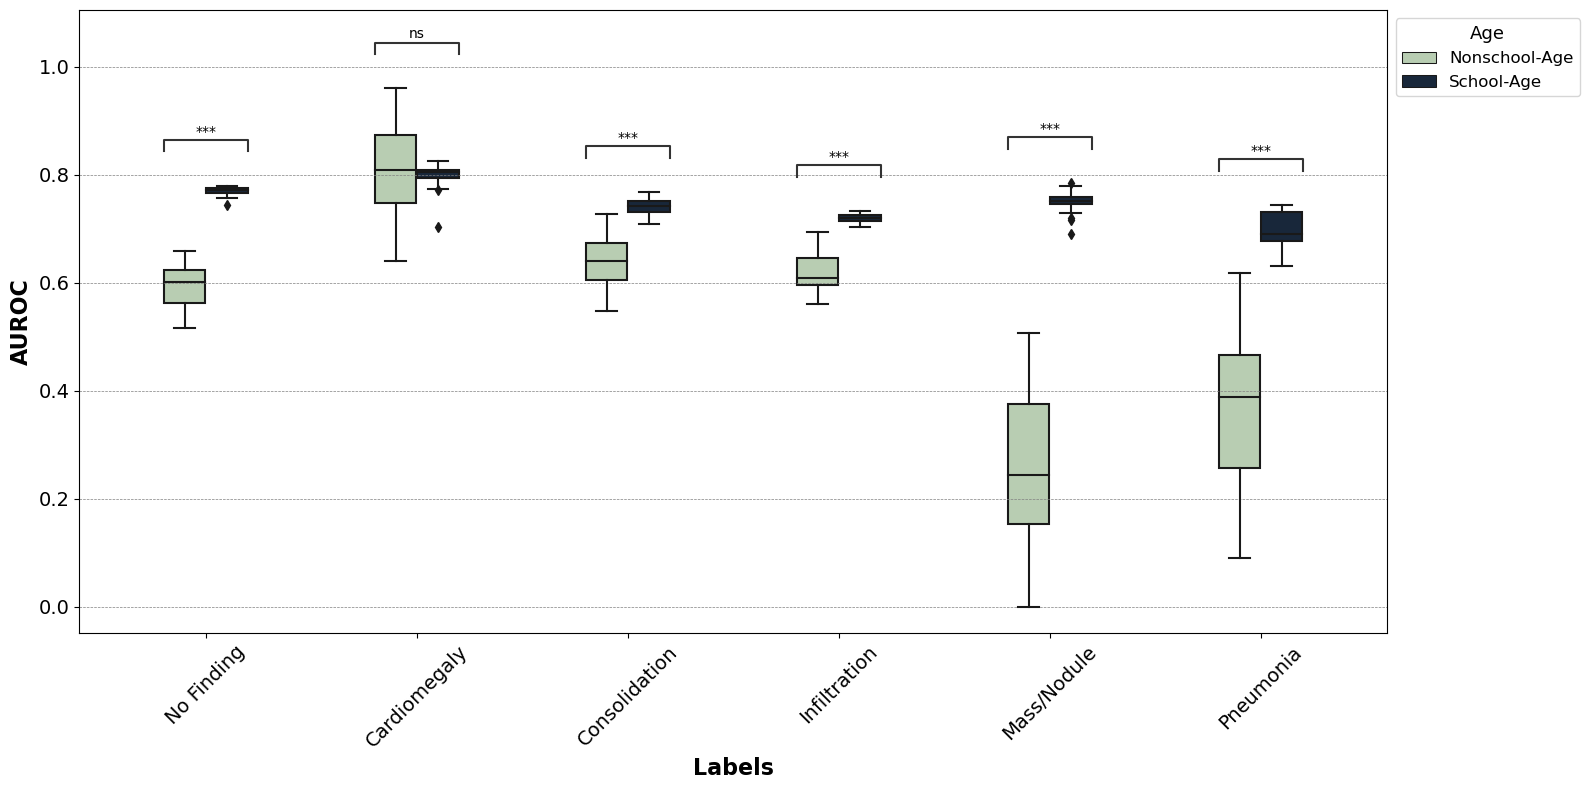

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: p <= 1.00e-03

Cardiomegaly_Nonschool-Age v.s. Cardiomegaly_School-Age: Custom statistical test, P_val:1.293e-04
No Finding_Nonschool-Age v.s. No Finding_School-Age: Custom statistical test, P_val:8.032e-03
Consolidation_Nonschool-Age v.s. Consolidation_School-Age: Custom statistical test, P_val:2.177e-11
Infiltration_Nonschool-Age v.s. Infiltration_School-Age: Custom statistical test, P_val:1.694e-10
Mass/Nodule_Nonschool-Age v.s. Mass/Nodule_School-Age: Custom statistical test, P_val:1.191e-17
Pneumonia_Nonschool-Age v.s. Pneumonia_School-Age: Custom statistical test, P_val:5.000e-08


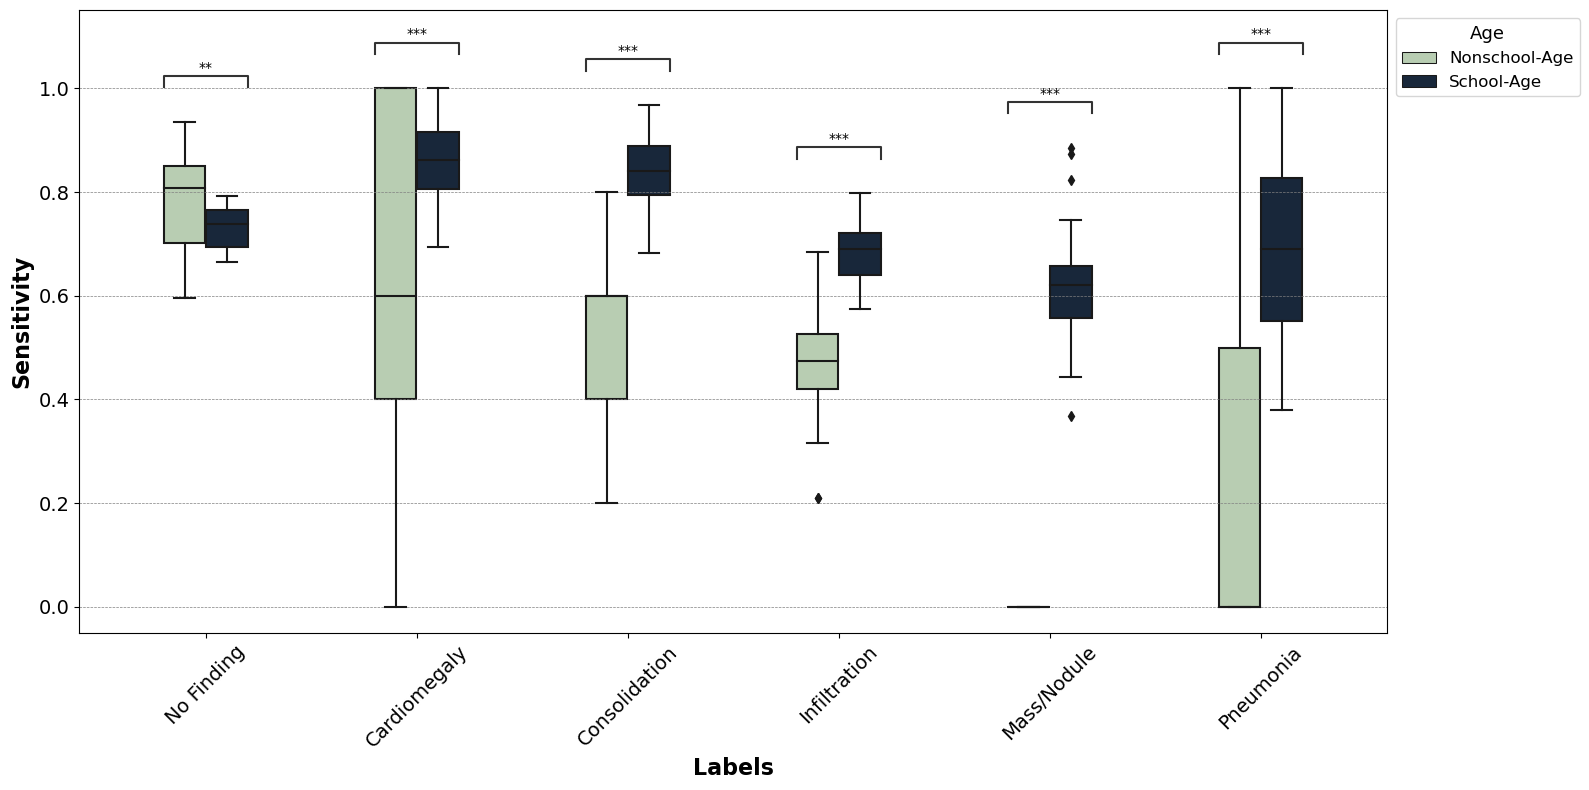

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: p <= 1.00e-03

Cardiomegaly_Nonschool-Age v.s. Cardiomegaly_School-Age: Custom statistical test, P_val:2.558e-14
No Finding_Nonschool-Age v.s. No Finding_School-Age: Custom statistical test, P_val:1.191e-17
Consolidation_Nonschool-Age v.s. Consolidation_School-Age: Custom statistical test, P_val:3.337e-09
Infiltration_Nonschool-Age v.s. Infiltration_School-Age: Custom statistical test, P_val:6.278e-03
Mass/Nodule_Nonschool-Age v.s. Mass/Nodule_School-Age: Custom statistical test, P_val:2.533e-07
Pneumonia_Nonschool-Age v.s. Pneumonia_School-Age: Custom statistical test, P_val:5.155e-06


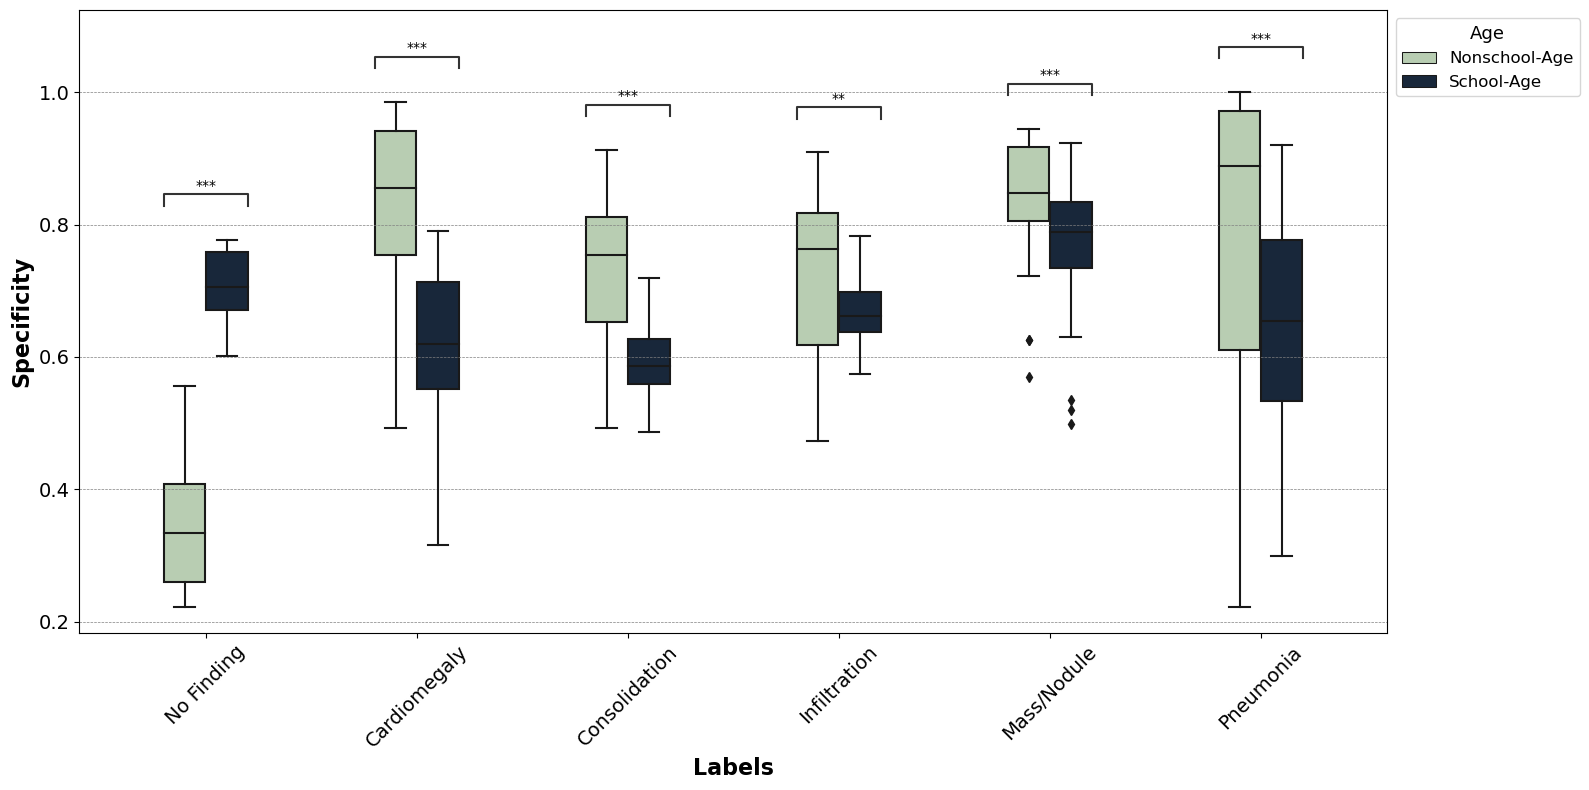

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: p <= 1.00e-03

Cardiomegaly_Nonschool-Age v.s. Cardiomegaly_School-Age: Custom statistical test, P_val:2.631e-05
No Finding_Nonschool-Age v.s. No Finding_School-Age: Custom statistical test, P_val:1.790e-15
Consolidation_Nonschool-Age v.s. Consolidation_School-Age: Custom statistical test, P_val:1.540e-01
Infiltration_Nonschool-Age v.s. Infiltration_School-Age: Custom statistical test, P_val:7.683e-04
Mass/Nodule_Nonschool-Age v.s. Mass/Nodule_School-Age: Custom statistical test, P_val:5.945e-16
Pneumonia_Nonschool-Age v.s. Pneumonia_School-Age: Custom statistical test, P_val:2.742e-07


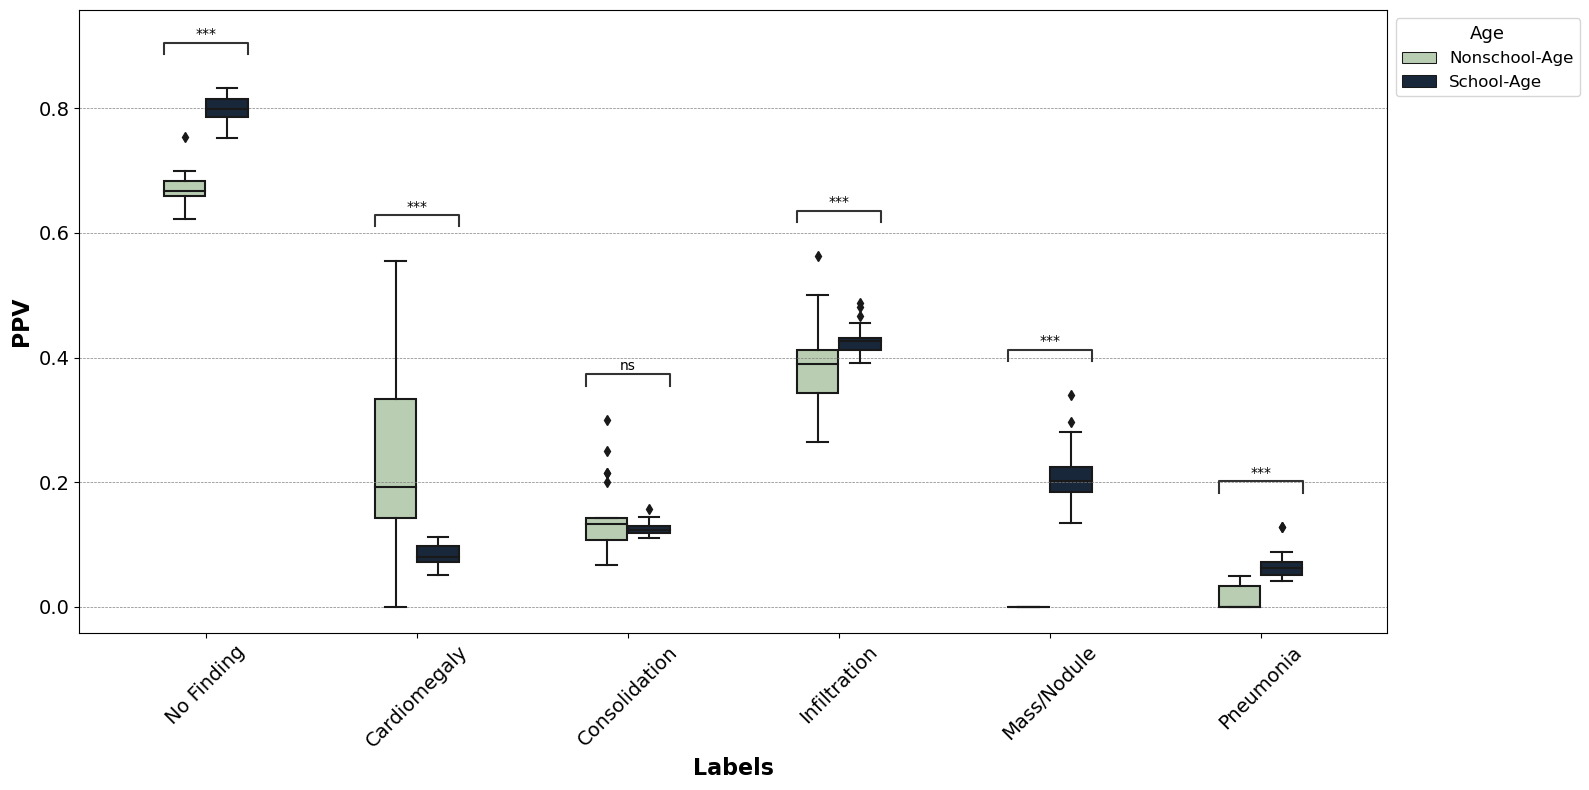

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: p <= 1.00e-03

Cardiomegaly_Nonschool-Age v.s. Cardiomegaly_School-Age: Custom statistical test, P_val:3.780e-05
No Finding_Nonschool-Age v.s. No Finding_School-Age: Custom statistical test, P_val:6.199e-08
Consolidation_Nonschool-Age v.s. Consolidation_School-Age: Custom statistical test, P_val:9.237e-11
Infiltration_Nonschool-Age v.s. Infiltration_School-Age: Custom statistical test, P_val:2.750e-10
Mass/Nodule_Nonschool-Age v.s. Mass/Nodule_School-Age: Custom statistical test, P_val:8.032e-03
Pneumonia_Nonschool-Age v.s. Pneumonia_School-Age: Custom statistical test, P_val:1.333e-04


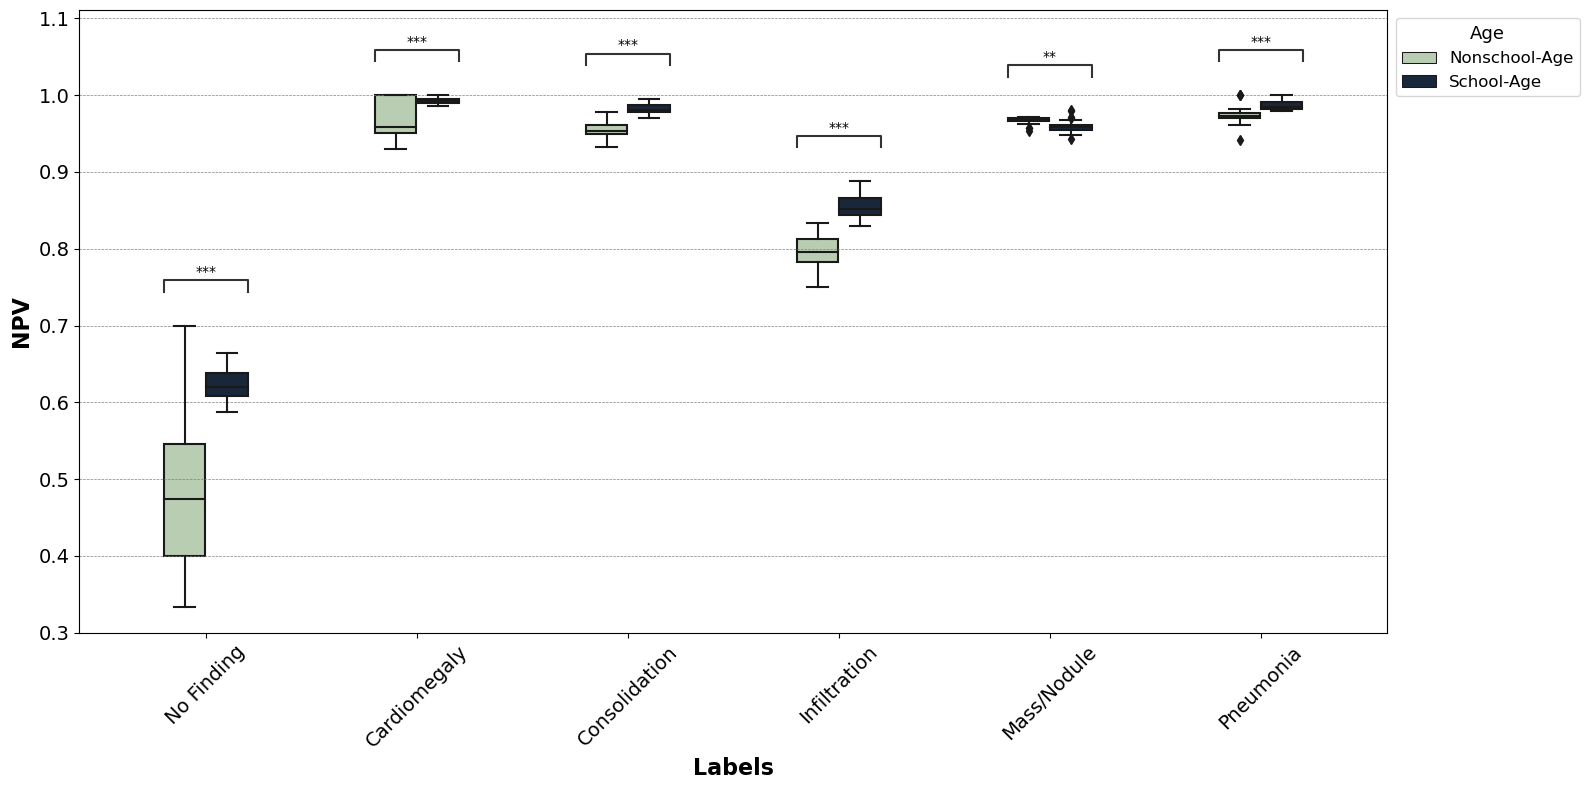

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: p <= 1.00e-03

Cardiomegaly_Nonschool-Age v.s. Cardiomegaly_School-Age: Custom statistical test, P_val:1.293e-04
No Finding_Nonschool-Age v.s. No Finding_School-Age: Custom statistical test, P_val:3.780e-05
Consolidation_Nonschool-Age v.s. Consolidation_School-Age: Custom statistical test, P_val:7.396e-01
Infiltration_Nonschool-Age v.s. Infiltration_School-Age: Custom statistical test, P_val:1.434e-09
Mass/Nodule_Nonschool-Age v.s. Mass/Nodule_School-Age: Custom statistical test, P_val:2.503e-21
Pneumonia_Nonschool-Age v.s. Pneumonia_School-Age: Custom statistical test, P_val:7.766e-08


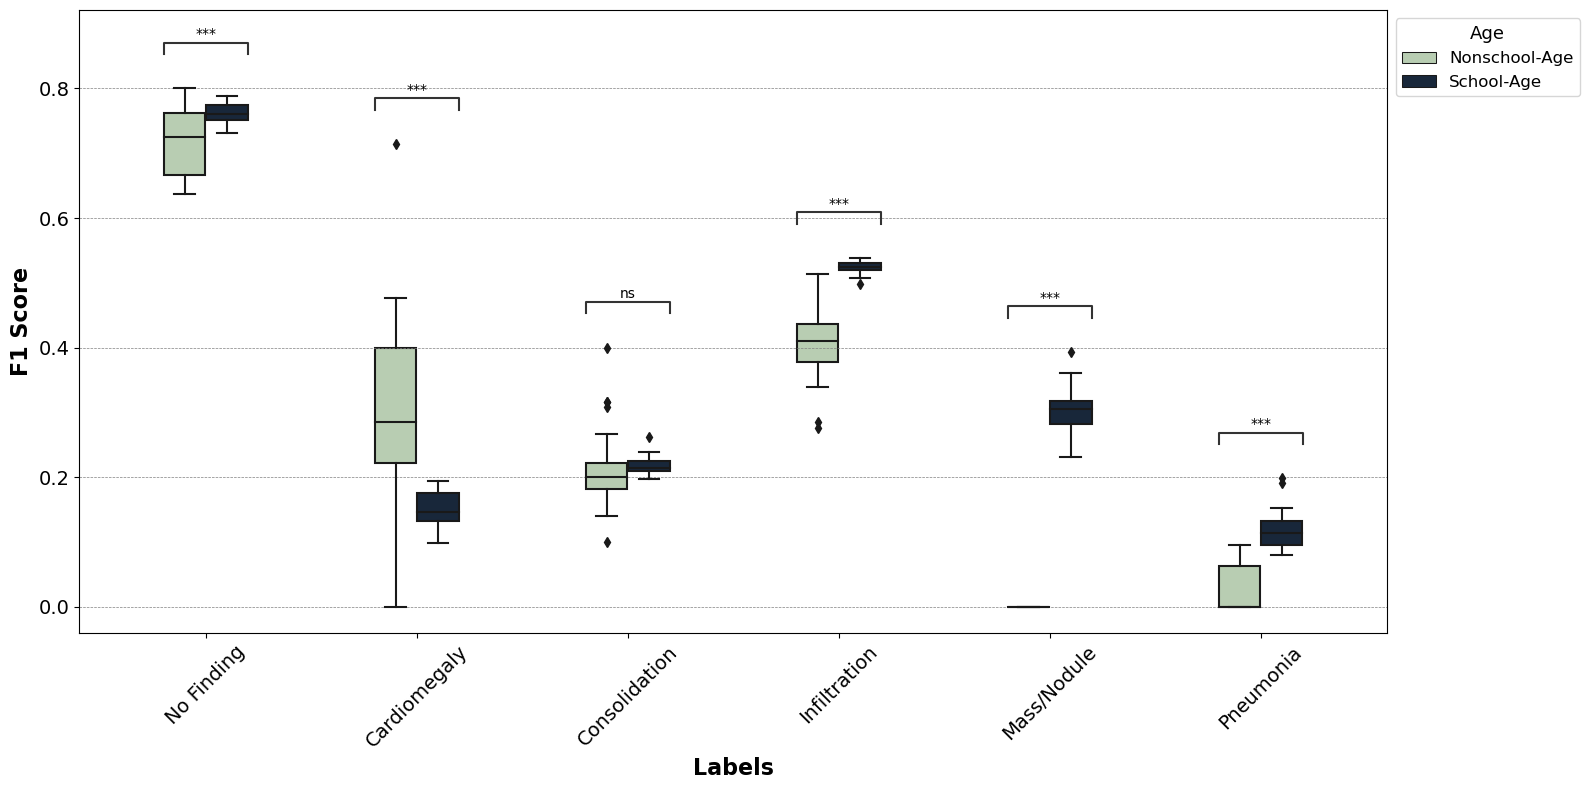

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: p <= 1.00e-03

Cardiomegaly_Nonschool-Age v.s. Cardiomegaly_School-Age: Custom statistical test, P_val:2.558e-14
No Finding_Nonschool-Age v.s. No Finding_School-Age: Custom statistical test, P_val:1.191e-17
Consolidation_Nonschool-Age v.s. Consolidation_School-Age: Custom statistical test, P_val:3.337e-09
Infiltration_Nonschool-Age v.s. Infiltration_School-Age: Custom statistical test, P_val:6.278e-03
Mass/Nodule_Nonschool-Age v.s. Mass/Nodule_School-Age: Custom statistical test, P_val:2.533e-07
Pneumonia_Nonschool-Age v.s. Pneumonia_School-Age: Custom statistical test, P_val:5.155e-06


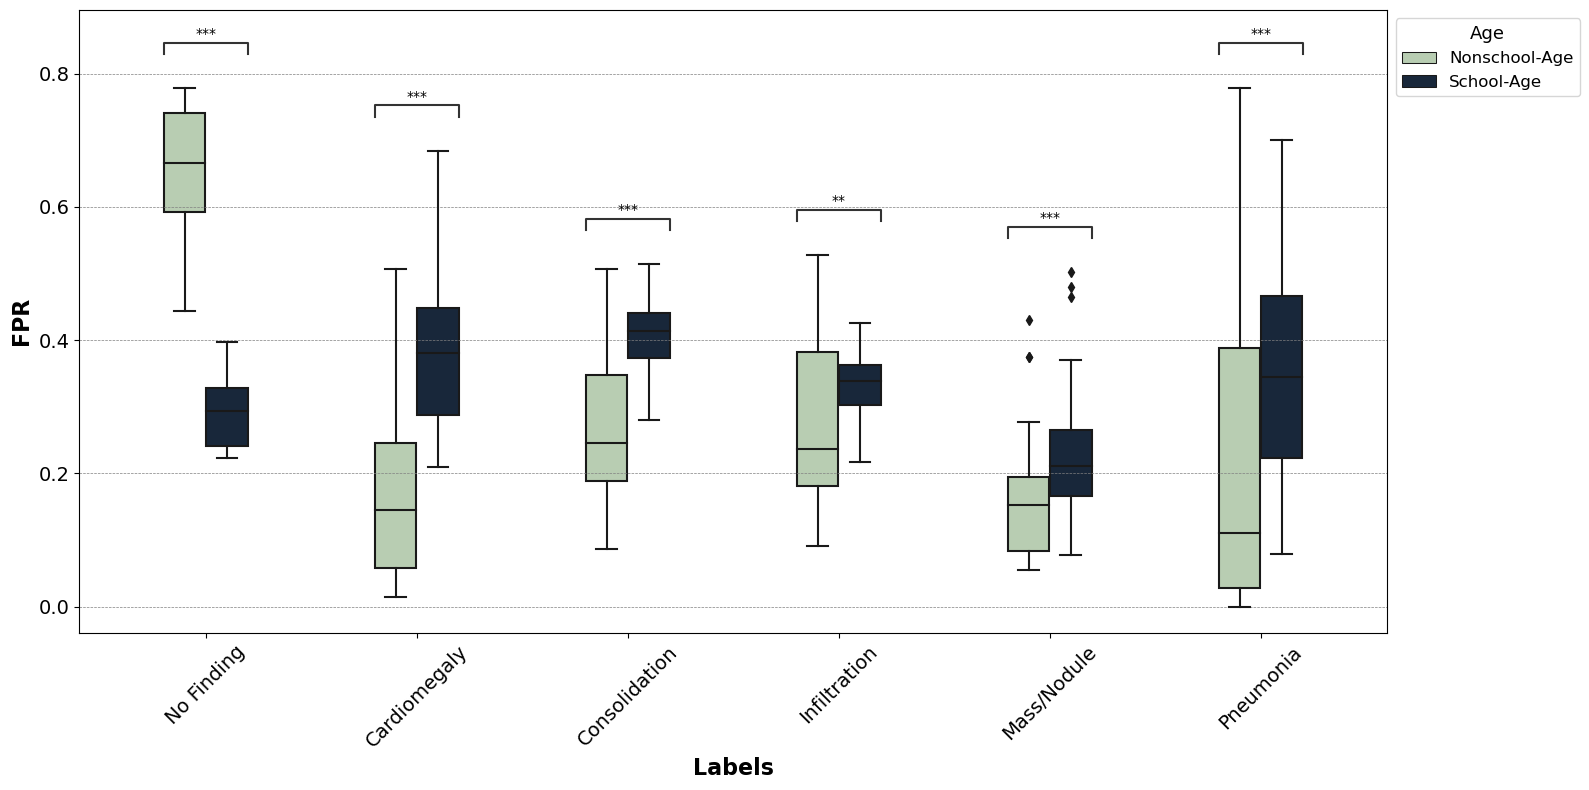

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: p <= 1.00e-03

Cardiomegaly_Nonschool-Age v.s. Cardiomegaly_School-Age: Custom statistical test, P_val:1.293e-04
No Finding_Nonschool-Age v.s. No Finding_School-Age: Custom statistical test, P_val:8.032e-03
Consolidation_Nonschool-Age v.s. Consolidation_School-Age: Custom statistical test, P_val:2.177e-11
Infiltration_Nonschool-Age v.s. Infiltration_School-Age: Custom statistical test, P_val:1.694e-10
Mass/Nodule_Nonschool-Age v.s. Mass/Nodule_School-Age: Custom statistical test, P_val:1.191e-17
Pneumonia_Nonschool-Age v.s. Pneumonia_School-Age: Custom statistical test, P_val:5.000e-08


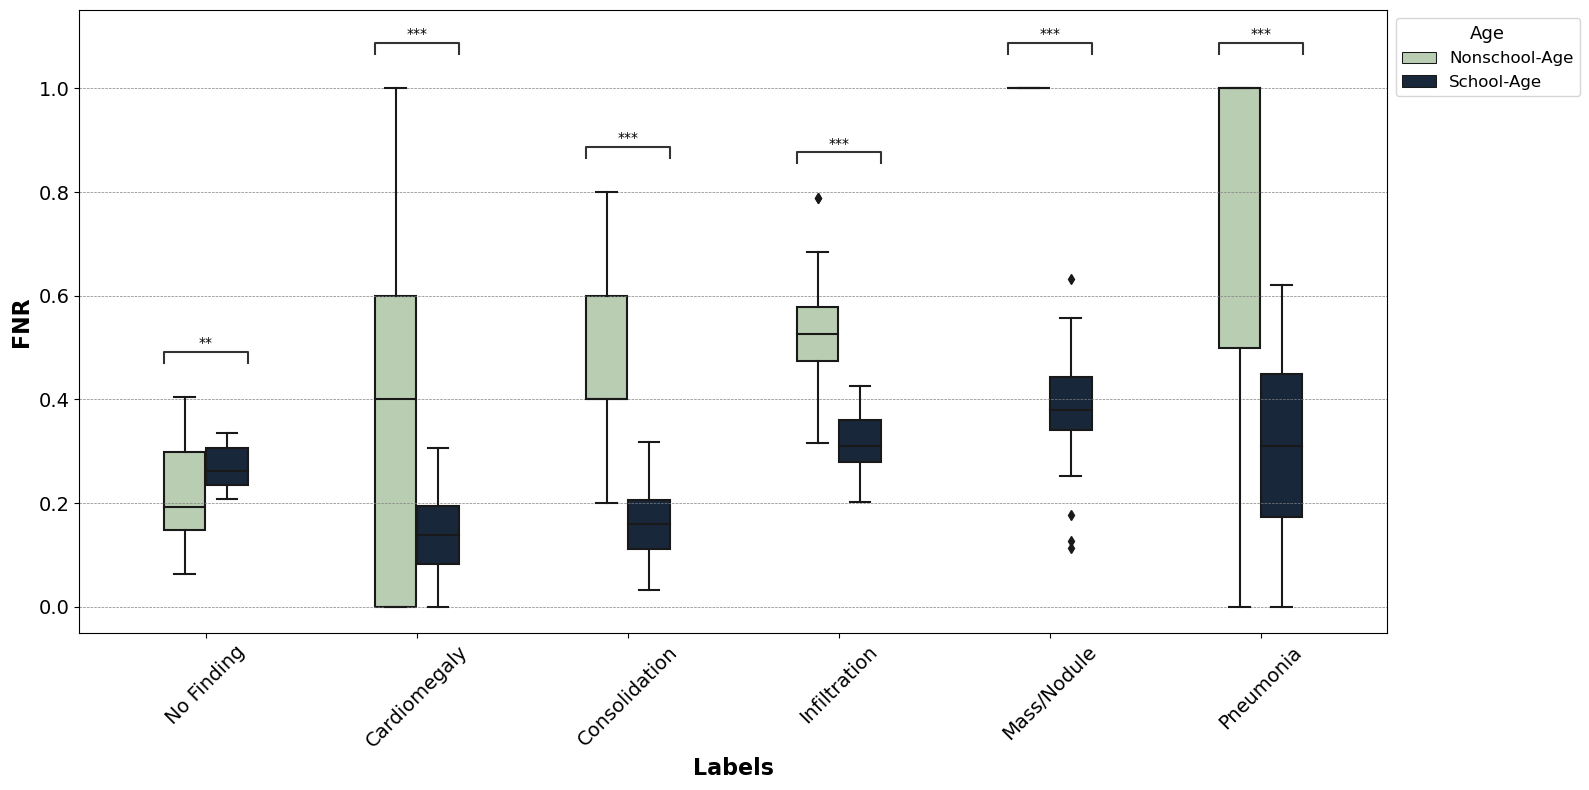

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from statannot import add_stat_annotation
import pandas as pd


parent = '/home/jkim/research/peds_cxr/'
gpu = "1"
predefined_seeds = [9,17,18,29,30,34,41,42,51,52,61,66,74,75,78,81,84,86,87,89,90,92,96,98,99]

# Define paths and read the CSV files
nih_age_stats = pd.read_csv(parent + "25variation/results/nih/analysis/csv/nih_age_stats.csv")
metrics_young_all = pd.read_csv(parent + "25variation/results/nih/analysis/csv/metrics_young_all.csv")
metrics_old_all = pd.read_csv(parent + "25variation/results/nih/analysis/csv/metrics_old_all.csv")

# Add sex column to metrics dataframes and combine them
metrics_young_all['Age'] = 'Nonschool-Age'
metrics_old_all['Age'] = 'School-Age'
combined_metrics = pd.concat([metrics_young_all, metrics_old_all])

# Extract unique metrics and labels
unique_metrics = nih_age_stats['Metric'].unique()
unique_labels = ["No Finding", "Cardiomegaly", "Consolidation", "Infiltration", "Mass/Nodule", "Pneumonia"]
neutral_palette = ["#b5d1ae", "#122740"]

for metric in unique_metrics:
    fig, ax = plt.subplots(figsize=(16, 8))
    sns.boxplot(x='Label', y=metric, hue='Age', data=combined_metrics, ax=ax, order=unique_labels, palette=neutral_palette, width=0.4)
    
    # Other plot adjustments
    ax.set_xlabel('Labels', fontsize=16, fontweight='bold')
    ax.set_ylabel(metric, fontsize=16, fontweight='bold')
    ax.tick_params(axis='x', labelsize=14, rotation=45)
    ax.tick_params(axis='y', labelsize=14)
    ax.grid(True, linestyle='--', linewidth=0.5, color='gray', axis='y')

    # Prepare a list of tuples for box_pairs
    box_pairs = [((label, 'Nonschool-Age'),(label, 'School-Age')) for label in unique_labels]
    
    # Extract p-values for each label and metric combination
    p_values = [nih_age_stats[(nih_age_stats['Metric'] == metric) & 
                                    (nih_age_stats['Label'] == label)]['p_value_after_BH'].values[0] 
                for label in unique_labels]
    
    # Add statistical annotation
    add_stat_annotation(ax, data=combined_metrics, x='Label', y=metric, hue='Age',
                        box_pairs=box_pairs, perform_stat_test=False, pvalues=p_values, 
                        test_short_name='Custom', loc='inside', verbose=2, 
                        pvalue_thresholds=[(0.001, '***'), (0.01, '**'), (0.05, '*'), (1, 'ns')])
    ax.legend(title='Age', title_fontsize='13', fontsize='12', loc='upper left', bbox_to_anchor=(1, 1))

    # Save the plot
    plt.tight_layout()
    plot_file_path = parent + f'25variation/results/nih/analysis/plot/age/{metric}_comparison.jpeg'
    plt.savefig(plot_file_path, format='jpeg')
    plt.show()
    plt.close(fig)
